In [1]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap
sns.set()
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [2]:
# Read in clean feather files -

jan = pd.read_feather("../preprocessed_data/clean_jan.feather").dropna().drop('index', axis=1)
feb = pd.read_feather("../preprocessed_data/clean_feb.feather").dropna().drop('index', axis=1)
mar = pd.read_feather("../preprocessed_data/clean_mar.feather").dropna().drop('index', axis=1)
apr = pd.read_feather("../preprocessed_data/clean_apr.feather").dropna().drop('index', axis=1)

In [ ]:
jan.shape

In [ ]:
feb.shape

In [ ]:
mar.shape

In [ ]:
apr.shape

In [3]:
# Concatenate all months into a single df and check that it's clean -

placeholder = jan.append(feb)
three_month = placeholder.append(mar)

display(three_month.shape)
display(three_month.isna().sum())

(15559108, 11)

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
tip_amount               0
total_amount             0
dtype: int64

In [ ]:
display(jan.describe())

In [ ]:
display(feb.describe())

In [ ]:
display(mar.describe())

In [ ]:
display(apr.describe())

# Feature Generation

In [ ]:
jan['tpep_pickup_datetime'].dt.day_name()

In [4]:
three_month['pickup_day'] = three_month['tpep_pickup_datetime'].dt.day_name()

In [5]:
three_month['pickup_time'] = three_month['tpep_pickup_datetime'].dt.hour
# In 24H time

In [ ]:
three_month.tail()

## Checking which days are busiest -

In [ ]:
ax = sns.countplot(y = 'pickup_day', data = three_month)
#ax.save('../plots/busy_days.html')
ax.set(xlabel = 'Trip Count Frequency', ylabel = 'Days of the Week')
plt.savefig('../plots/busy_days.png')

# plt.savefig cuts off the left side, couldn't find a fix. So just saved with snipping tool. Labelled as busy_days_proper

## Checking what time of day is busiest -

In [ ]:
ax = sns.countplot(y = 'pickup_time', data = three_month)
ax.set(xlabel = 'Trip Count Frequency', ylabel = 'Time of Day (24H)')
#plt.savefig('../plots/busy_times.png')

## What time of day on Wed / Thur/ Fri are busiest -

In [15]:
wednesday = three_month.loc[three_month['pickup_day'] == 'Wednesday']
thursday = three_month.loc[three_month['pickup_day'] == 'Thursday']
friday = three_month.loc[three_month['pickup_day'] == 'Friday']

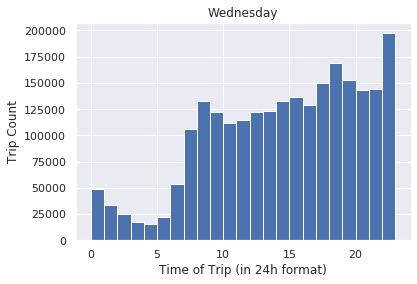

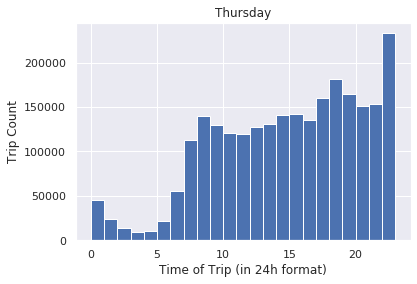

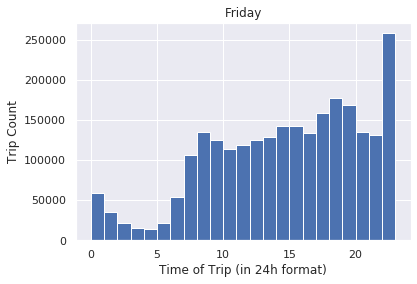

In [16]:
wednesday['pickup_time'].plot.hist(grid = True, bins = 23)
plt.title('Histogram of average Wednesday trip frequency')
plt.xlabel('Time of Trip (in 24h format)')
plt.ylabel('Trip Count')
plt.title('Wednesday')
#plt.savefig('../plots/wed_times.png')
plt.show()

thursday['pickup_time'].plot.hist(grid = True, bins = 23)
plt.title('Histogram of average Thursday trip frequency')
plt.xlabel('Time of Trip (in 24h format)')
plt.ylabel('Trip Count')
plt.title('Thursday')
#plt.savefig('../plots/thur_times.png')
plt.show()

friday['pickup_time'].plot.hist(grid = True, bins = 23)
plt.title('Histogram of average Friday trip frequency')
plt.xlabel('Time of Trip (in 24h format)')
plt.ylabel('Trip Count')
plt.title('Friday')
#plt.savefig('../plots/fri_times.png')
plt.show()

## Checking what inner city zones are busiest -

In [6]:
sf = gpd.read_file("../raw_data/taxi_zones.shp")
zone = pd.read_csv("../raw_data/taxi+_zone_lookup.csv")

# Code taken from Tutorial 2 for the subject
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [7]:
# Code taken from Tutorial 2 for the subject
gdf = gpd.GeoDataFrame(pd.merge(three_month, sf, left_on = 'PULocationID', right_on = 'LocationID')).drop('PULocationID', axis = 1)

geoJSON = gdf[['LocationID','geometry']].drop_duplicates('LocationID').to_json()

In [8]:
# Create column for how many trips recorded in each zone

three_month['count'] = 1
three_month.groupby('PULocationID')['count'].count()

PULocationID
1        1712
2          12
3         180
4       25677
5          60
        ...  
261     83320
262    211556
263    308576
264    103300
265      7216
Name: count, Length: 262, dtype: int64

In [9]:
# Filtering out some random PULocationIDs of large numbers. IDs 1-264 correspond to areas in NYC, whereas other IDs are unexplained

filtered_zones = three_month.loc[three_month['PULocationID'] < 264]
filtered_zones.tail()

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
2969680  2020-03-31 23:18:36   2020-03-31 23:21:26              5.0   
2969681  2020-03-31 23:39:18   2020-03-31 23:50:17              5.0   
2969682  2020-03-31 23:24:48   2020-03-31 23:31:54              5.0   
2969683  2020-03-31 23:41:03   2020-03-31 23:44:23              6.0   
2969684  2020-03-31 23:57:09   2020-04-01 00:06:52              6.0   

         trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
2969680           0.52         1.0           236           236           2.0   
2969681           2.35         1.0           263           166           1.0   
2969682           1.33         1.0           140           162           1.0   
2969683           0.87         1.0           140           229           1.0   
2969684           2.80         1.0           140           100           1.0   

         fare_amount  tip_amount  total_amount pickup_day  pickup_time  count  
2969680          4.0        0.00          7.80    Tuesday           23      1  
2969681         10.5        2.86         17.16    Tuesday           23      1  
2969682          7.0        2.20         13.00    Tuesday           23      1  
2969683          5.0        2.64         11.44    Tuesday           23      1  
2969684         10.5        1.00         15.30    Tuesday           23      1

In [10]:
counts = three_month.groupby('PULocationID').count()
counts

tpep_pickup_datetime  tpep_dropoff_datetime  passenger_count  \
PULocationID                                                                 
1                             1712                   1712             1712   
2                               12                     12               12   
3                              180                    180              180   
4                            25677                  25677            25677   
5                               60                     60               60   
...                            ...                    ...              ...   
261                          83320                  83320            83320   
262                         211556                 211556           211556   
263                         308576                 308576           308576   
264                         103300                 103300           103300   
265                           7216                   7216             7216   

              trip_distance  RatecodeID  DOLocationID  payment_type  \
PULocationID                                                          
1                      1712        1712          1712          1712   
2                        12          12            12            12   
3                       180         180           180           180   
4                     25677       25677         25677         25677   
5                        60          60            60            60   
...                     ...         ...           ...           ...   
261                   83320       83320         83320         83320   
262                  211556      211556        211556        211556   
263                  308576      308576        308576        308576   
264                  103300      103300        103300        103300   
265                    7216        7216          7216          7216   

              fare_amount  tip_amount  total_amount  pickup_day  pickup_time  \
PULocationID                                                                   
1                    1712        1712          1712        1712         1712   
2                      12          12            12          12           12   
3                     180         180           180         180          180   
4                   25677       25677         25677       25677        25677   
5                      60          60            60          60           60   
...                   ...         ...           ...         ...          ...   
261                 83320       83320         83320       83320        83320   
262                211556      211556        211556      211556       211556   
263                308576      308576        308576      308576       308576   
264                103300      103300        103300      103300       103300   
265                  7216        7216          7216        7216         7216   

               count  
PULocationID          
1               1712  
2                 12  
3                180  
4              25677  
5                 60  
...              ...  
261            83320  
262           211556  
263           308576  
264           103300  
265             7216  

[262 rows x 13 columns]

In [11]:
gdf = gpd.GeoDataFrame(pd.merge(counts, sf, left_on = 'PULocationID', right_on = 'LocationID'))

In [ ]:
gdf.tail()

In [12]:
m_ride_count = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=gdf, # data source
    columns=['LocationID','count'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='OrRd', # color scheme
    fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Trips' # legend title
).add_to(m_ride_count)

m_ride_count

In [13]:
#m_ride_count.save('../plots/location_heatmap.png')
# save fn didn't work, so just used snipping tool again